In [1]:
from imports import *

2024-06-27 12:21:09.062151: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 12:21:09.085329: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 12:21:09.085349: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 12:21:09.085364: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 12:21:09.090271: I tensorflow/core/platform/cpu_feature_g

In [2]:
sys.path.append('src')
from process_data import DataProcessor
from vanilla_transformer import Transformer
from visualize_data import Visualizer
from train_model import ModelTrainer
from load_data import DataLoader
model_trainer = ModelTrainer()
data_processor = DataProcessor()
visualizer = Visualizer()
data_loader = DataLoader()

In [3]:
data, pip_factor = data_loader.load_usdcad_1min()

In [4]:
input_seq_len = 96
output_seq_len = 30

train_pct = 0.6
val_pct = 0.2

In [5]:
b, a = butter(5, 1/12, btype='low', analog=False)
data['bw_close'] = filtfilt(b, a, data['close'])

In [6]:
data['rsi_close_15'] = abstract.RSI(data, timeperiod=15, price='close')
data['rsi_close_60'] = abstract.RSI(data, timeperiod=60, price='close')
data['atr_14'] = abstract.ATR(data, timeperiod=14)
slowk, slowd = talib.STOCH(data['high'], data['low'], data['close'])
data['slowk'] = slowk
data['slowd'] = slowd


In [7]:
data.dropna(how='any', axis=0, inplace=True)

In [8]:
data, _ = data_processor.normalize_custom(data, train_pct, ['volume', 'rsi_close_15', 'rsi_close_60', 'atr_14', 'slowk', 'slowd'])

In [9]:
target_time = data[['time', 'bw_close', 'close']]

In [10]:
target = data[['close', 'bw_close']]

In [11]:
data.drop(['open', 'high', 'low', 'close'], axis=1, inplace=True)

In [12]:
Xdata, ydata = model_trainer.create_Xy_data(data, target, input_seq_len, output_seq_len)

In [13]:
np.random.seed(42)
shuffled_indices = np.random.permutation(Xdata.shape[0])
Xdata = Xdata[shuffled_indices]
ydata = ydata[shuffled_indices]

In [14]:
Xtrain_time, ytrain_c, Xval_time, yval_c, Xtest_time, ytest_c = model_trainer.split_data(Xdata, ydata, train_pct, val_pct)

In [15]:
# discard time column
Xtrain = (Xtrain_time[:, :, 1:]).astype(np.float64)
Xval = (Xval_time[:, :, 1:]).astype(np.float64)
Xtest = (Xtest_time[:, :, 1:]).astype(np.float64)

# discard original close price column, keep only filtered close price column
ytrain = ytrain_c[:, :, 1:]
yval = yval_c[:, :, 1:]
ytest = ytest_c[:, :, 1:]

In [16]:
# parameters of the transformer model
config = {
    'input_seq_len': input_seq_len,
    'output_seq_len': output_seq_len,
    'multihead_attn_heads': 8,
    'd_k': 32,
    'd_v': 32,
    'd_ff': 32,
    'd_out': ytrain.shape[-1],
    'd_model': 32,
    'encoder_layers': 1,
    'decoder_layers': 1,
    'dropout_rate': 0.1,
    'activation': 'relu',
    'batch_size': 32,
}

In [17]:
epochs = 20

path = 'saved_models/tf-absolute-96in-30out.h5'

model = model_trainer.load_model_transformer(path, Xtest, config)

#model = Transformer(config)

2024-06-27 12:21:21.225172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9315 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [18]:
#model, best_epoch, train_losses, val_losses = model_trainer.train_model_transformer(Xtrain, ytrain, Xval, yval, path, epochs, model, 1e-3, config, Xtest)

### not enough space, split the data

In [20]:
file_path1 = 'saved_models/tf_predict_price_predictions'
file_path2 = 'saved_models/tf_predict_price_predictions2'
file_path3 = 'saved_models/tf_predict_price_predictions3'
file_path4 = 'saved_models/tf_predict_price_predictions4'

In [31]:
# import pickle
# tmp0 = Xtest.shape[0]//4
# tmp1 = tmp0+tmp0
# tmp2 = tmp1+tmp0

# file_path1 = 'saved_models/tf_predict_price_predictions'

# with tf.device('/CPU:0'):
#     pred1 = model(Xtest[:tmp0], target=None, training=False)

# with open(file_path1, 'wb') as f:
#     pickle.dump(pred1, f)

In [19]:
# file_path2 = 'saved_models/tf_predict_price_predictions2'

# with tf.device('/CPU:0'):
#     pred2 = model(Xtest[tmp0:tmp1], target=None, training=False)

# with open(file_path2, 'wb') as f:
#     pickle.dump(pred2, f)

In [ ]:
# file_path3 = 'saved_models/tf_predict_price_predictions3'

# with tf.device('/CPU:0'):
#     pred3 = model(Xtest[tmp1:tmp2], target=None, training=False)

# with open(file_path3, 'wb') as f:
#     pickle.dump(pred3, f)

In [ ]:
# file_path4 = 'saved_models/tf_predict_price_predictions4'

# with tf.device('/CPU:0'):
#     pred4 = model(Xtest[tmp2:], target=None, training=False)

# with open(file_path4, 'wb') as f:
#     pickle.dump(pred4, f)

In [ ]:
with open(file_path1, 'rb') as f:
    pred_part1 = pickle.load(f)

with open(file_path2, 'rb') as f:
    pred_part2 = pickle.load(f)

with open(file_path3, 'rb') as f:
    pred_part3 = pickle.load(f)

with open(file_path4, 'rb') as f:
    pred_part4 = pickle.load(f)

pred = tf.concat([pred_part1, pred_part2, pred_part3, pred_part4], axis=0)

pred.shape, Xtest.shape

In [29]:
Xtest.shape

(15963, 96, 7)

### Evaluation

In [31]:
close_idx = 1
last_closes_input_seqs = list(Xtest[:, -1, close_idx])
last_closes_output_seqs = list(ytest[:, -1, 0])
last_closes_pred_seqs = list(pred[:, -1, 0])

In [32]:
real_price_movement = [a-b for a, b in zip(last_closes_output_seqs, last_closes_input_seqs)]
pred_price_movement = [a-b for a, b in zip(last_closes_pred_seqs, last_closes_input_seqs)]

In [33]:
real_classes = data_processor.create_binary_classification_classes(real_price_movement, 0.0)
pred_classes = data_processor.create_binary_classification_classes(pred_price_movement, 0.0)

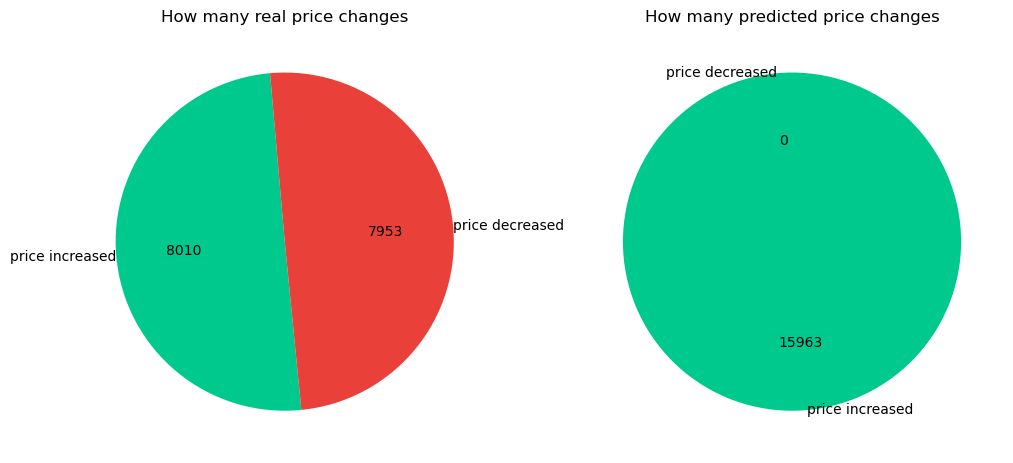

In [34]:
visualizer.pie_number_of_price_movements_binary(real_classes, pred_classes)

In [35]:
accuracy, precision, recall, f1 = data_processor.create_metrics_from_classes_binary(real_classes, pred_classes)
visualizer.create_metrics_df(accuracy, precision, recall, f1)

,Metric,Value
0,Accuracy,0.501785
1,Precision,0.501785
2,Recall,1.000000
3,F1 Score,0.668252
